In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

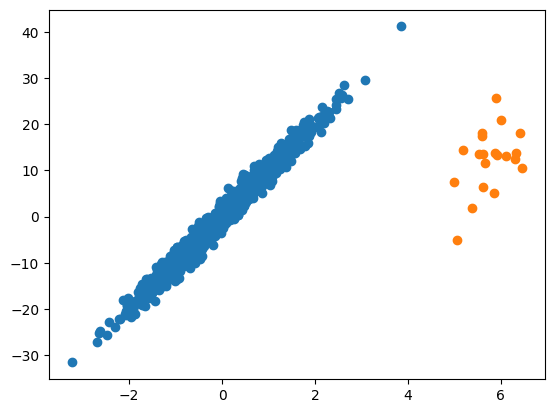

In [2]:
np.random.seed(42)

x = np.random.normal(scale=1, size=1000)
y = 10*x + np.random.normal(scale=1.5, size=x.size)

plt.scatter(x, y)

x2 = np.random.normal(loc=6, scale=0.5, size=20)
y2 = 2*x2 + np.random.normal(scale=5, size=x2.size)
plt.scatter(x2, y2)

In [19]:
samples = np.vstack([
    np.hstack([x, x2]),
    np.hstack([y, y2]),
])
labels = np.hstack([np.ones(x.size), -np.ones(x2.size)])

samples_best_fit = np.vstack([x, y])

In [4]:
# influence functions

In [67]:
def get_hessian(xs, damp): 
    return (xs @ xs.T + damp * np.eye(len(xs))) / len(xs)

def get_gradient(xi, yi, theta, damp):
    return ((theta * xi) - yi) * xi + damp * theta

def get_influence_score(xs, ys, x_test, y_test, theta, damp):
    hess = get_hessian(xs.reshape(1,-1), damp)
    test_grad = get_gradient(x_test, y_test, theta, damp)
    s_test = test_grad * (hess**-1)

    scores = []
    for xi, yi in zip(xs, ys):
        train_grad = get_gradient(xi, yi, theta, damp)
        score = s_test * train_grad
        scores.append(score.item())

    return scores

def get_optimal_param(xs, ys, damp):
    return (sum(xs**2) + damp) ** -1 * sum(xs*ys)

def show_chart(samples, samples_best_fit, test_example, damp):
    coef = get_optimal_param(samples[0], samples[1], damp)
    coef_best_fit = get_optimal_param(samples_best_fit[0], samples_best_fit[1], damp)
    
    scores = get_influence_score(samples[0], samples[1], test_example[0], test_example[1], coef, damp=1e-2)

    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=min(scores), vmax=max(scores))
    sc = ax1.scatter(samples[0], samples[1], c=scores, cmap="RdBu", norm=norm)
    ax1.scatter(*test_example, c="darkgreen", s=100, marker="+", label="test sample")
    plt.colorbar(sc)
    
    sc = ax2.scatter(samples[0], samples[1], c=np.sign(scores), cmap="RdBu")
    ax2.scatter(*test_example, c="darkgreen", s=100, marker="+", label="test sample")
    
    # best line of fit
    x_pred = np.linspace(-4, 6, num=1000) ## TODO: dynamic xrange
    y_pred = coef_best_fit * x_pred
    ax1.plot(x_pred, y_pred, c="k", ls="--", label="Line of best fit w/o outliers")
    ax2.plot(x_pred, y_pred, c="k", ls="--", label="Line of best fit w/o outliers")
    
    # linear regression
    x_pred = np.linspace(-4, 6, num=1000)
    y_pred = coef * x_pred
    ax1.plot(x_pred, y_pred, c="C7", ls="--", label="Line of best fit")
    ax2.plot(x_pred, y_pred, c="C7", ls="--", label="Line of best fit")

    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    
    return scores

def show_diagnostics(scores, samples, coef):
    _, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))

    ax1.hist(scores, bins=100)
    ax1.set_xlabel("Influence scores")
    ax1.set_ylabel("Number of training samples")
    ax1.set_title("Histogram of influence scores")

    norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=min(scores), vmax=max(scores))
    resids = np.abs(coef * samples[0] - samples[1])
    ax2.scatter(resids, scores, c=scores, cmap="RdBu", norm=norm)
    ax2.set_xlabel("Residuals")
    ax2.set_ylabel("Influence scores")
    ax2.set_title("Influence score vs (absolute) residuals")
    
    plt.tight_layout()

# def show_quantiles(scores):
#     plt.plot(np.arange(98), np.quantile(scores, q=np.linspace(0, 1, 101))[1:-2])

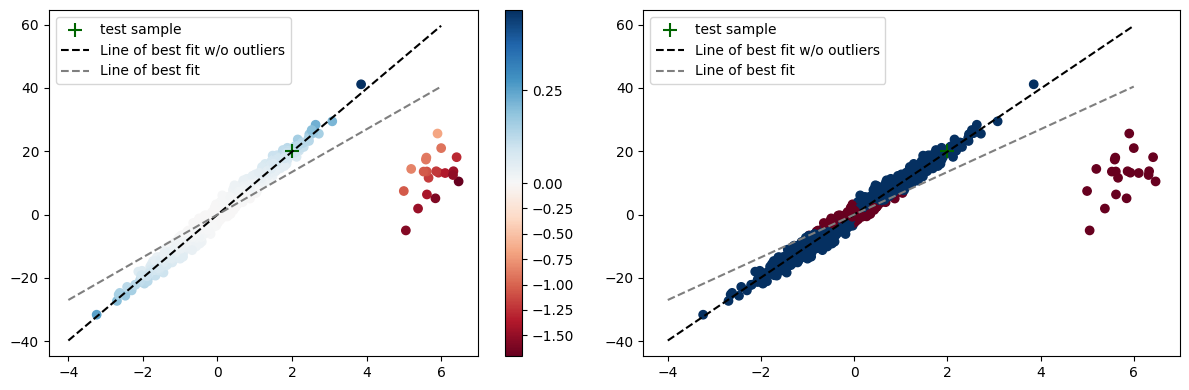

In [74]:
_ = show_chart(samples, samples_best_fit, test_example=(2,20), damp=1e-2)

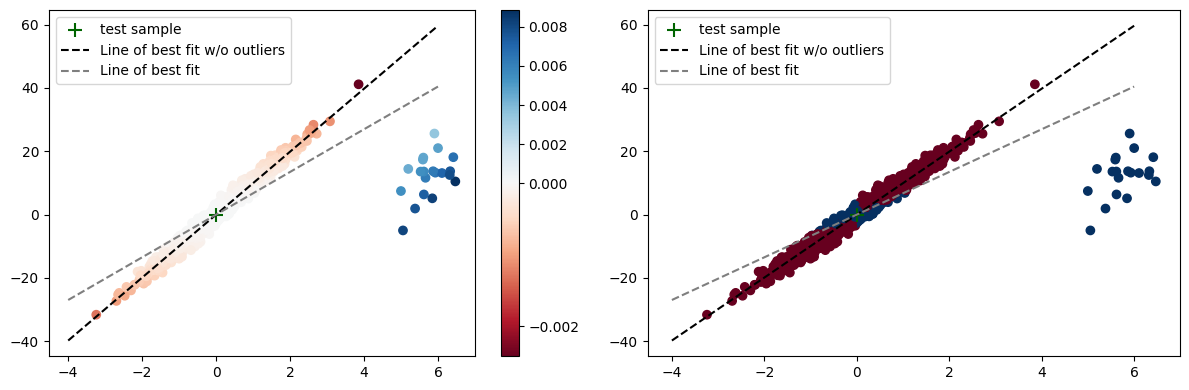

In [75]:
_ = show_chart(samples, samples_best_fit, test_example=(0,0), damp=1e-2)

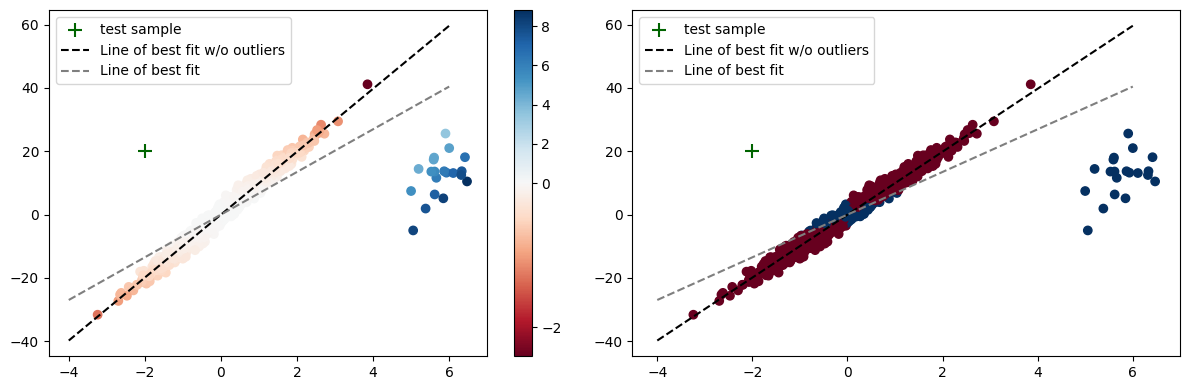

In [76]:
_ = show_chart(samples, samples_best_fit, test_example=(-2,20), damp=1e-2)

In [112]:
# decision boundary

grid_x = np.linspace(-4, 6, 101)
grid_y = np.linspace(-40, 60, 101)

matches = []
for gx in grid_x:
    for gy in grid_y:
        test_example = (gx,gy)

        coef = get_optimal_param(samples[0], samples[1], damp=1e-2)
        scores = get_influence_score(samples[0], samples[1], test_example[0], test_example[1], coef, damp=1e-2)
        
        true_labels = labels
        pred_labels = np.sign(scores)
        match = (true_labels == pred_labels).mean()
        # match = 1 if match > 0.5 else 0
        matches.append((gx, gy, match))

matches = np.array(matches)

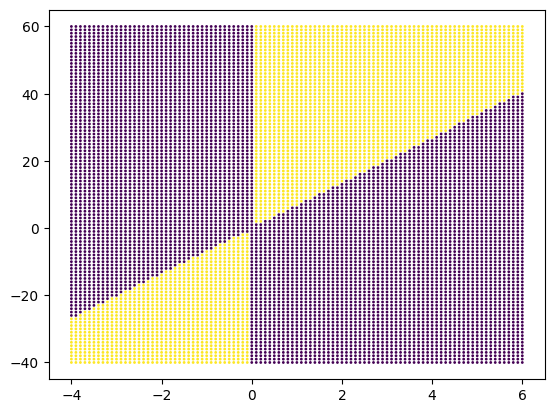

In [113]:
plt.scatter(matches[:,0], matches[:,1], c=matches[:,2], s=1);

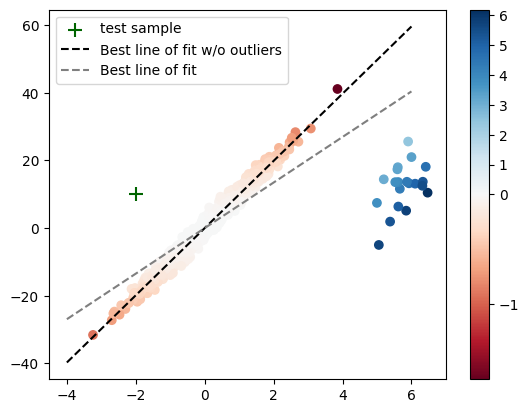

In [56]:
test_example = (-2, 10)

coef = get_optimal_param(samples[0], samples[1], damp)
coef_best_fit = get_optimal_param(samples_best_fit[0], samples_best_fit[1], damp)

scores = get_influence_score(samples[0], samples[1], test_example[0], test_example[1], coef, damp=1e-2)

norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=min(scores), vmax=max(scores))
sc = plt.scatter(samples[0], samples[1], c=scores, cmap='RdBu', norm=norm)
plt.scatter(*test_example, c="darkgreen", s=100, marker="+", label="test sample")

# best line of fit
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef_best_fit * x_pred
plt.plot(x_pred, y_pred, c="k", ls="--", label="Best line of fit w/o outliers")

# linear regression
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef * x_pred
plt.plot(x_pred, y_pred, c="C7", ls="--", label="Best line of fit")

plt.colorbar(sc)
plt.legend()

Does this example illustrate that in OOD settings, influence functions fail catastrophically?

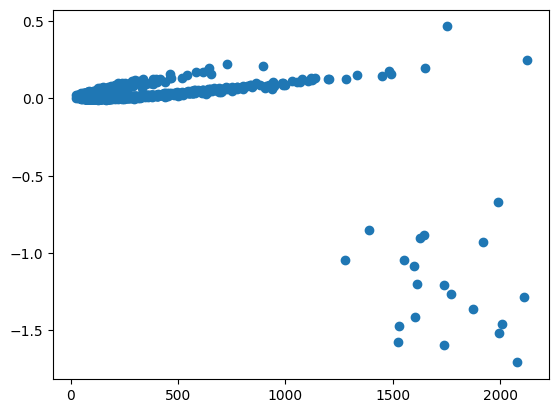

In [47]:
test_example = (-2, 10)
dists = []
for (xi, yi) in zip(samples[0], samples[1]):
    dist = (coef*xi - test_example[0])**2 + (yi - test_example[1])**2
    dists.append(dist)

plt.scatter(dists, scores)

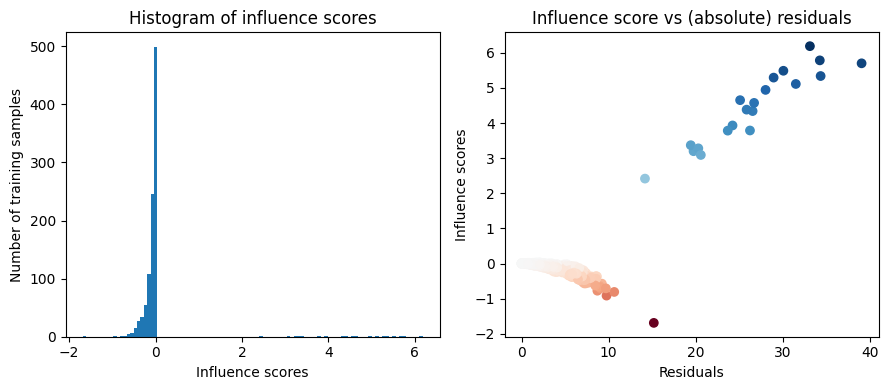

In [42]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))

ax1.hist(scores, bins=100)
ax1.set_xlabel("Influence scores")
ax1.set_ylabel("Number of training samples")
ax1.set_title("Histogram of influence scores")

resids = np.abs(reg.coef_ * samples[0] - samples[1])
ax2.scatter(resids, scores, c=scores, cmap="RdBu", norm=norm)
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Influence scores")
ax2.set_title("Influence score vs (absolute) residuals")

plt.tight_layout()

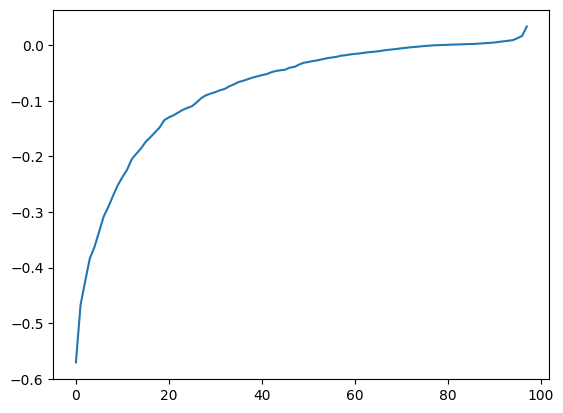

In [43]:
# quantile plot
plt.plot(np.arange(98), np.quantile(scores, q=np.linspace(0, 1, 101))[1:-2])

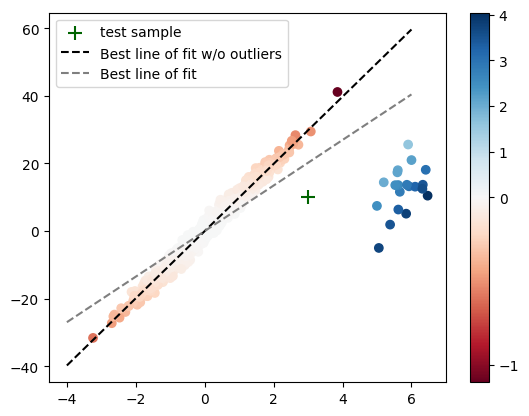

In [20]:
coef = get_optimal_param(samples[0], samples[1], damp)
coef_best_fit = get_optimal_param(samples_best_fit[0], samples_best_fit[1], damp)

scores = get_influence_score(samples[0], samples[1], 3, 10, coef, damp=1e-2)

norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=min(scores), vmax=max(scores))
sc = plt.scatter(samples[0], samples[1], c=scores, cmap='RdBu', norm=norm)
plt.scatter(3, 10, c="darkgreen", s=100, marker="+", label="test sample")

# best line of fit
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef_best_fit * x_pred
plt.plot(x_pred, y_pred, c="k", ls="--", label="Best line of fit w/o outliers")

# linear regression
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef * x_pred
plt.plot(x_pred, y_pred, c="C7", ls="--", label="Best line of fit")

plt.colorbar(sc)
plt.legend()

We would intuitively expect the influence score of a training sample to indicate whether the sample contributes to moving the regression line towards the test output or away when it is removed from the training set.

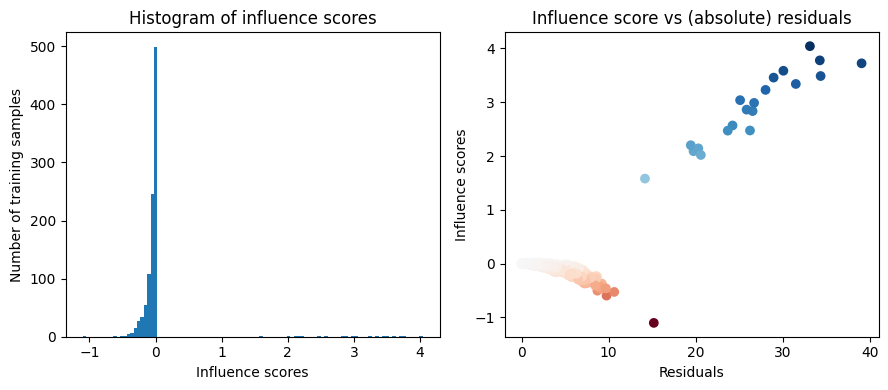

In [21]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))

ax1.hist(scores, bins=100)
ax1.set_xlabel("Influence scores")
ax1.set_ylabel("Number of training samples")
ax1.set_title("Histogram of influence scores")

resids = np.abs(reg.coef_ * samples[0] - samples[1])
ax2.scatter(resids, scores, c=scores, cmap="RdBu", norm=norm)
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Influence scores")
ax2.set_title("Influence score vs (absolute) residuals")

plt.tight_layout()

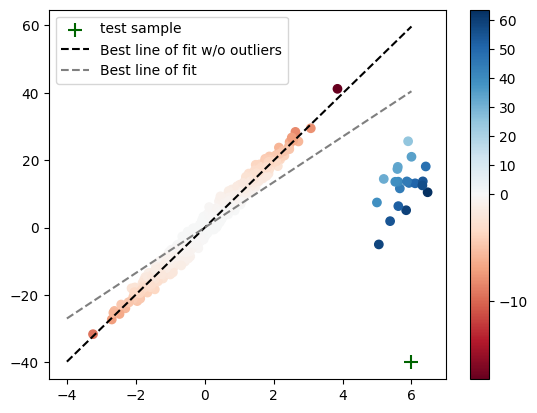

In [22]:
coef = get_optimal_param(samples[0], samples[1], damp)
coef_best_fit = get_optimal_param(samples_best_fit[0], samples_best_fit[1], damp)

scores = get_influence_score(samples[0], samples[1], 6, -40, coef, damp=1e-2)

norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=min(scores), vmax=max(scores))
sc = plt.scatter(samples[0], samples[1], c=scores, cmap='RdBu', norm=norm)
plt.scatter(6, -40, c="darkgreen", s=100, marker="+", label="test sample")

# best line of fit
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef_best_fit * x_pred
plt.plot(x_pred, y_pred, c="k", ls="--", label="Best line of fit w/o outliers")

# linear regression
x_pred = np.linspace(-4, 6, num=1000)
y_pred = coef * x_pred
plt.plot(x_pred, y_pred, c="C7", ls="--", label="Best line of fit")

plt.colorbar(sc)
plt.legend()

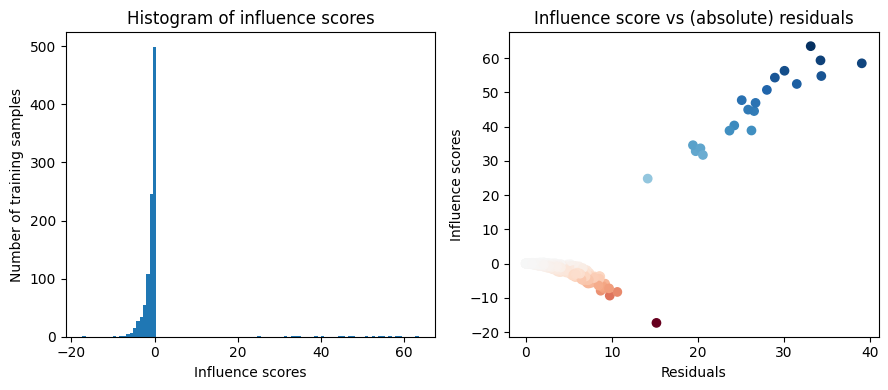

In [23]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))

ax1.hist(scores, bins=100)
ax1.set_xlabel("Influence scores")
ax1.set_ylabel("Number of training samples")
ax1.set_title("Histogram of influence scores")

resids = np.abs(reg.coef_ * samples[0] - samples[1])
ax2.scatter(resids, scores, c=scores, cmap="RdBu", norm=norm)
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Influence scores")
ax2.set_title("Influence score vs (absolute) residuals")

plt.tight_layout()